## Import Libraries

In [1]:
import pandas as pd
import json
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

## Load Data

In [2]:
firebase_data = 'data.json'
with open(firebase_data, 'r') as infile:
    data = json.load(infile)
query_ids = list(data.keys())

In [3]:
assessor_info = 'assessor_info.tsv'
assessor_df = pd.read_csv(assessor_info,delimiter='\t',encoding='utf-8',header=None)
assessor_df.columns = ["user_id","email","consent","contact","english","progress","assessed_queries"]

In [5]:
qrels_filename = 'qrels.dev.small.tsv'
qrels_df = pd.read_csv(qrels_filename,delimiter='\t',encoding='utf-8',header=None)
qrels_df.columns = ['query_id','label1','passage_id','label2']

## Create DataFrames per Query

In [7]:
def create_labels(nr_assessors):
    labels = ["query_id","passageid","msmarco"]
    for i in range(nr_assessors):
        labels = labels + ['user%s_id'%(i+1),'user%s_label'%(i+1)]
    return labels

In [8]:
dataframe_data = {}
label_data = {}
assessor_data = {}
for query_id in query_ids:
    query_data_lists = []
    query_data = data[query_id]
    nr_assessors = 0
    for i, passage_id in enumerate(query_data.keys()):
        dataFrameRow2be = [query_id, passage_id] + query_data[passage_id]
        query_data_lists.append(dataFrameRow2be)
        if i == 0:
            nr_assessors = int((len(query_data[passage_id])-1)/2)
    dataframe_data[query_id] = query_data_lists
    label_data[query_id] = create_labels(nr_assessors)
    assessor_data[query_id] = nr_assessors

In [9]:
dataframes = {}
for query_id in query_ids:
    df = pd.DataFrame(dataframe_data[query_id],columns=label_data[query_id])
    dataframes[query_id] = df

## Gather Experiment Queries

In [13]:
assessors_do_not_agree = ["838453", "866251", "321951", "427323", "993987", "540906"]
msmarco_only_relevant = ["335710", "489257"]
at_least_3 = []
for query_id in query_ids:
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        at_least_3.append(query_id)
experiment_query_ids = [int(query_id) for query_id in at_least_3 if (not (query_id in assessors_do_not_agree)) and (not (query_id in msmarco_only_relevant))]

## Compute Nr Relevant MS MARCO Dataset

In [16]:
og_relevance_count = {}
for query_id in experiment_query_ids:
    og_relevance_count[query_id] = len(qrels_df[qrels_df['query_id'] == query_id])

Now lets plot these numbers in a bar plot

In [26]:
counts = Counter(og_relevance_count.values())

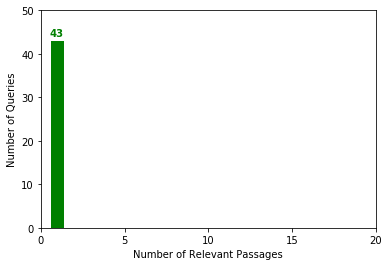

In [36]:
fig, ax = plt.subplots() 
ax.bar(list(counts.keys()), counts.values(), color='g')
for i, v in enumerate(counts.values()):
    ax.text(i+0.5, v + 1 , str(v), color='g', fontweight='bold')
ax.set_ylim([0,50])
ax.set_xlim([0,20])
ax.set_xticks([0,5,10,15,20])
plt.xlabel("Number of Relevant Passages")
plt.ylabel("Number of Queries")
plt.show()

## Compute Nr Relevant T=2 Dataset

In [21]:
t2_dataset_df = pd.read_csv('thesis_dataset_binary_threshold2.tsv',delimiter='\t',encoding='utf-8',header=None)
t2_dataset_df.columns = ['query_id','label1','passage_id','label2']

In [22]:
t2_relevance_count = {}
for query_id in experiment_query_ids:
    t2_relevance_count[query_id] = len(t2_dataset_df[t2_dataset_df['query_id'] == query_id])

In [48]:
counts = Counter(t2_relevance_count.values())

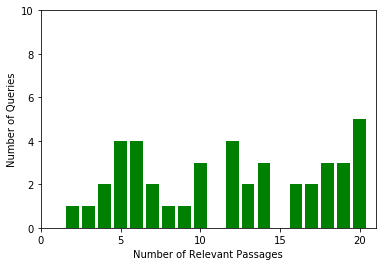

In [58]:
fig, ax = plt.subplots() 
ax.bar(counts.keys(), counts.values(), color='g')
ax.set_ylim([0,10])
ax.set_xlim([0,21])
ax.set_xticks([0,5,10,15,20])
plt.xlabel("Number of Relevant Passages")
plt.ylabel("Number of Queries")
plt.show()

## Compute Nr Relevant T=3 dataset

In [83]:
t3_dataset_df = pd.read_csv('thesis_dataset_binary_threshold3.tsv',delimiter='\t',encoding='utf-8',header=None)
t3_dataset_df.columns = ['query_id','label1','passage_id','label2']

In [84]:
t3_relevance_count = {}
for query_id in experiment_query_ids:
    t3_relevance_count[query_id] = len(t3_dataset_df[t3_dataset_df['query_id'] == query_id])

In [85]:
counts = Counter(t3_relevance_count.values())

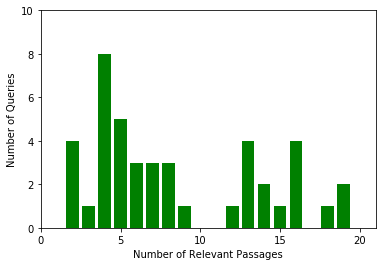

In [86]:
fig, ax = plt.subplots() 
ax.bar(counts.keys(), counts.values(), color='g')
ax.set_ylim([0,10])
ax.set_xlim([0,21])
ax.set_xticks([0,5,10,15,20])
plt.xlabel("Number of Relevant Passages")
plt.ylabel("Number of Queries")
plt.show()

## Make shared boxplot

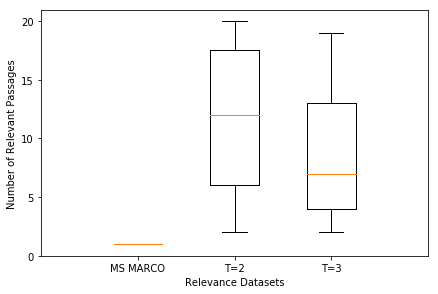

In [90]:
data_a = [list(og_relevance_count.values())]
data_b = [list(t2_relevance_count.values())]
data_c = [list(t3_relevance_count.values())]

ticks = ['MS MARCO', 'T=2', 'T=3']

plt.figure()

bp1 = plt.boxplot(data_a,positions=[0],widths=1)
bp2 = plt.boxplot(data_b,positions=[2],widths=1)
bp3 = plt.boxplot(data_c,positions=[4],widths=1)
plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.yticks(range(0,21,5))
plt.tight_layout()
plt.xlabel("Relevance Datasets")
plt.ylabel("Number of Relevant Passages")
plt.savefig('images/experiment_queries_relevance_boxplots.png', bbox_inches='tight')
plt.show()